## Part 1: KNN

* *Warm up exercises: K-nearest-neighbors*

>*How does K-nearest-neighbors work? Explain in your own words.*

K-nearest-neighbors is a machine learning classification algorithm. It classifies each data point according to its nearest neighbors. K holds for the number of neighbors. Thus, if K=3 means that each point will be classified according to its 3 nearest neighbors.

>*Explain in your own words: What is the curse of dimensionality? Use figure 12-6 to as part of your explanation.*

<img  src="TYIT4EFGSA7D2PLAYVS0L3BDUVQSHS04.png"/>

The curse of dimensionality means that when the **dimensionality** increases, the **volume** of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.

* *Exercise: K-nearest-neighbors map.*

>*The goal of this exercise is to create a useful real-world version of the example on pp153 in DSFS. We know from last week's exercises that the focus crimes PROSTITUTION, DRUG/NARCOTIC and DRIVING UNDER THE INFLUENCE tend to be concentrated in certain neighborhoods, so we focus on those crime types since they will make the most sense a KNN - map.*

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from collections import Counter
import operator
import numpy as np
%matplotlib inline
# mpld3.enable_notebook()
from bokeh.plotting import figure, output_notebook, show
from bokeh.charts import Bar, output_file, show
import seaborn as sns
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from sklearn.neighbors import KNeighborsClassifier
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import pyglet

In [2]:
# Define the data path
data_path = 'SFPD_data.csv'

In [3]:
# Load it into a Dataframe using pandas
raw_file = pd.read_csv(data_path)
df = pd.DataFrame(raw_file)
df.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [4]:
# Define the focused crimes in a list and create a filtered dataframe
more_focusedcrimes = ['PROSTITUTION','DRUG/NARCOTIC','DRIVING UNDER THE INFLUENCE']
df_focused = df.filter(items=['Category', 'X','Y'])
df_focused = df_focused[df_focused['Category'].isin(more_focusedcrimes)]
df_focused.head()

,Category,X,Y
11,DRUG/NARCOTIC,-122.413354,37.769075
12,DRUG/NARCOTIC,-122.413354,37.769075
31,DRUG/NARCOTIC,-122.419520,37.764229
41,DRUG/NARCOTIC,-122.419828,37.766674
61,DRIVING UNDER THE INFLUENCE,-122.420692,37.790577


>*Begin by using geoplotlib to plot all incidents of the three crime types on their own map using geoplotlib.kde(). This will give you an idea of how the various crimes are distributed across the city.*

In [5]:
# Remove the outliers from the previous week's exercise
df_focused = df_focused[df_focused['Y']<39]

# Createa dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict = {}
for crime in more_focusedcrimes:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_focused[df_focused['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(df_focused[df_focused['Category']==crime]['X'])]}
    geo_dict[crime] = geo_data_for_plotting

#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_focused['Y'])]
longs = [float(el) for el in list(df_focused['X'])]
print 'Latitudes:',set([round(el) for el in lats])
print 'Longitudes:',set([round(el) for el in longs])

Latitudes: set([38.0])
Longitudes: set([-123.0, -122.0])


In [6]:
#Ready for plotting
colors = ['red', 'green', 'blue']

for i,crime in enumerate(more_focusedcrimes):
    # Create a legend
    print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict[crime]['lon']),crime)
    # Fit the map with dots
    geoplotlib.dot(geo_dict[crime], color=colors[i], point_size=.8)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()


red		 ----->		16161 observations		 ----->		PROSTITUTION
green		 ----->		115124 observations		 ----->		DRUG/NARCOTIC
blue		 ----->		5302 observations		 ----->		DRIVING UNDER THE INFLUENCE


>*Next, it's time to set up your model based on the actual data. You can use the code supplied in the book or try out scikit-learn's KNeighborsClassifier. If you end up using the latter (recommended), you may want to check out this example to get a sense of the usage.*

>*You don't have to think a lot about testing/trainig and accuracy for this exercise. We're mostly interested in creating a map that's not too problematic. But do calculate the number of observations of each crime-type respectively. You'll find that the levels of each crime varies (lots of drug arrests, an intermediate amount of prostitiution registered, and very little drunk driving in the dataset). Since the algorithm classifies each point according to it's neighbors, what could a consequence of this imbalance in the number of examples from each class mean for your map?*

As we can see from the map most of the dots are green meaning that they are more DRUG related crimes, then goes the red, which is PROSTITUTION and then the blue which is DRIVING UNDER THE INFLUENCE. According to the above, the classifier will most likely fit those with the highest number of observations together with those with lower.

> *You can make the dataset 'balanced' by grabbing an equal number of examples from each crime category. How do you expect that will change the KNN result? In which situations is the balanced map useful - and when is the map that data in proportion to occurrences useful? Choose which map you will work on in the following.*

By modifying the number of occurences of each category to a balanced number for all of them, we can fit an unbiased classifier.

* *Now create an approximately square grid of point that runs over SF. You get to decide the grid-size, but I recommend somewhere between 50×50 and 100×100 points. I recommend plotting using geoplotlib.dot().*

In [7]:
# Randomly sample 99 elements from your dataframe, 33 from each category
helper_df = pd.DataFrame(columns = ['Category','X','Y'])
for crime in more_focusedcrimes:
    df_focused_sample = df_focused[df_focused['Category']==crime].sample(n=3333)
    helper_df = pd.concat([df_focused_sample,helper_df])

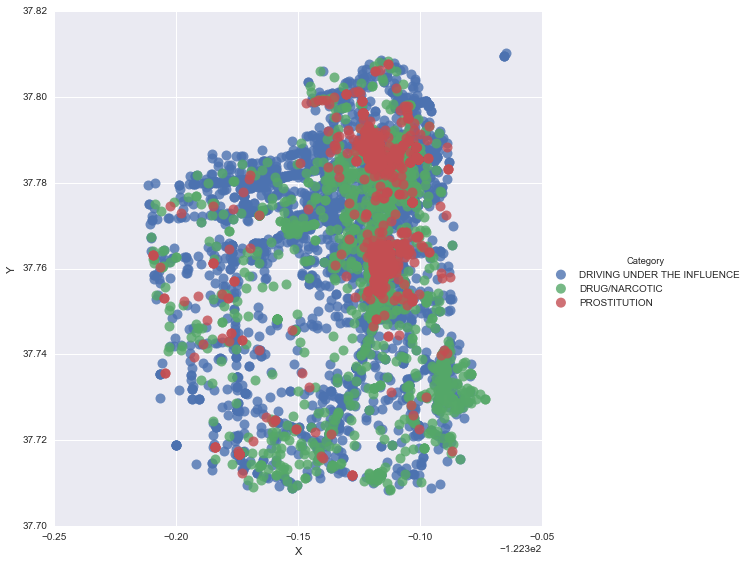

In [8]:
# Create a simple plot of the dataset before the classification
sns.lmplot('X', 'Y', data=helper_df, fit_reg=False,hue="Category", size=8,scatter_kws={"marker": "D","s": 100})

In [17]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_b = {}
for crime in more_focusedcrimes:
    geo_data_for_plotting_b = {"lat": [float(el) for el in list(helper_df[helper_df['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(helper_df[helper_df['Category']==crime]['X'])]}
    geo_dict_b[crime] = geo_data_for_plotting_b
    
#Ready for plotting
for i,crime in enumerate(more_focusedcrimes):
    # Create a legend
    print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict_b[crime]['lon']),crime)
    # Fit the map with dots
    geoplotlib.dot(geo_dict_b[crime], color=colors[i], point_size=1)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()


red		 ----->		3333 observations		 ----->		PROSTITUTION
green		 ----->		3333 observations		 ----->		DRUG/NARCOTIC
blue		 ----->		3333 observations		 ----->		DRIVING UNDER THE INFLUENCE


If you a take a close look at the position of the dots on the map it resebles the scatter plot from above. Now we can fit our model.

* *Visualize your model by coloring the grid, coloring each grid point according to it's category. Create a plot of this kind for models where each point is colored according to the majority of its 5, 10, and 30 nearest neighbors. Describe what happens to the map as you increase the number of neighbors, K.*

### Before classification

In [31]:
class CustomLayer(BaseLayer):

    def __init__(self, data):
        self.data = data

    def invalidate(self, proj):
        x, y = proj.lonlat_to_screen(self.data['X'], self.data['Y'])
        self.painter = BatchPainter()
        #self.painter.points(x, y)
        #self.cmap = create_set_cmap(set(data['Category']),'hsv' ) #'hsv'
        self.cmap = {'DRIVING UNDER THE INFLUENCE': [0, 15, 255, 255], 'PROSTITUTION': [255, 0, 0, 255], 'DRUG/NARCOTIC': [7, 255, 0, 255]}
        
        for crime in set(data['Category']):
            self.painter.set_color(self.cmap[crime]) #self.cmap[crime]
            self.painter.points(x[data['Category'] == crime], y[data['Category'] == crime], 3)
            self.painter.convexhull(x[data['Category'] == crime], y[data['Category'] == crime])
        

    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        self.painter.batch_draw()
        
data = helper_df
geoplotlib.add_layer(CustomLayer(data))
geoplotlib.set_smoothing(True)
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

### KNN with 5,10 and 30 nearest neighbors

In [30]:
class KNeighbors(BaseLayer):

    def __init__(self, data,k):
        self.data = data
        self.k = k # starting number of classifiers


    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        features = np.array(helper_df[['X','Y']]) # saves features for the classifier
        labels = np.array(helper_df['Category']) # sasves labels for the classifier
        x, y = proj.lonlat_to_screen(self.data['X'], self.data['Y']) # creates 2 arrays of numbers corresponding to lon and lat

        # Train the KNN classifier
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        pred = clf.predict(features) # creates an array of predicted crime categories

        # Create autogenerated colormap per crime
        #self.cmap = create_set_cmap(set(labels), 'hsv') # change 'hsv' with 'inferno' or 'hot'
        self.cmap = {'DRIVING UNDER THE INFLUENCE': [0, 15, 255, 255], 'PROSTITUTION': [255, 0, 0, 255], 'DRUG/NARCOTIC': [7, 255, 0, 255]}
        for crime in set(labels):
            self.painter.set_color(self.cmap[crime]) # picks 1 of 3 different colors randomly
            self.painter.points(x[pred == crime], y[pred == crime], 3) # paints the points according to predicted crimes
            self.painter.convexhull(x[pred == crime], y[pred == crime]) # creates the polygons around the points
    
    # Map interaction. Increase/Decrease number of neighbors        
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()

data = helper_df
k_numbers=[5,10,30]
for k in k_numbers:
    
    geoplotlib.add_layer(KNeighbors(data,k))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                           west=min(geo_data_for_plotting['lon']),
                           south=min(geo_data_for_plotting['lat']),
                           east=max(geo_data_for_plotting['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    #geoplotlib.show() # if you want to see the interaction with the neighbors
    #We have to fix the colors

## Part 2 Linear Regression

* *Just a few questions to check that you've read the material.*

>*What's the point of the error term ϵi? (That one wasn't around when you learned how to figure out the slope and y intercept of straight lines in high school).*

εi is a small error term representing the fact that there are other factors not accounted for by the simple model. It is usually refered as noise.

* *Why do you think Joel figures out how to find α and β using gradient descent when we already know how to find the best values analytically?*

Because he needed a better way to figure out how well he would have fit the data than plotting at a graph first. A common measure is the coefficient of determination (or R-squared), which measures the fraction of the total variation in the dependent variable that is captured by the model. He chose the alpha and beta that minimized the sum of the squared prediction errors.

## Part 3: Building an understanding of Multiple Regression and Logistic Regression